In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
import os.path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import csv
import re
import os.path
from random import randint
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Parameters

In [2]:
BATCH_SIZE = 64
LSTM_UNITS = 64
NUM_CLASSES = 16
ITERATIONS = 20000
MAX_SEQ_LENGTH = 100
WORD_DIM = 100

## Utilities

In [3]:
### Load pretrained word2vec model
def load_pretrained_words():
    pretrained = pd.read_table('glove.6B.100d.txt', header=None, delimiter=' ', quoting=csv.QUOTE_NONE)
    word_list = pretrained.loc[:,0].tolist()
    word_vectors = pretrained.loc[:,1:].values
    
    return word_list, word_vectors


### Preprocess the string
def clean_str(string):
    '''
    https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    '''
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)     
    string = re.sub(r"\'s", " \'s", string) 
    string = re.sub(r"\'ve", " \'ve", string) 
    string = re.sub(r"n\'t", " n\'t", string) 
    string = re.sub(r"\'re", " \'re", string) 
    string = re.sub(r"\'d", " \'d", string) 
    string = re.sub(r"\'ll", " \'ll", string) 
    string = re.sub(r",", " , ", string) 
    string = re.sub(r"!", " ! ", string) 
    string = re.sub(r"\(", " \( ", string) 
    string = re.sub(r"\)", " \) ", string) 
    string = re.sub(r"\?", " \? ", string) 
    string = re.sub(r"\s{2,}", " ", string) 
    return string.lower()



def load_data():
    '''
    load the following data: category, views, likes, dislikes, description, word_list, word_vectors
    return as several numpy arrays
    also return the word lists and words' vectors
    
    read csv, save the id matrix to a file for the first time
    directly load the id matrix and labels after the first time

    '''
    word_list, word_vectors = load_pretrained_words()  
    data = pd.read_csv('USvideos.csv', usecols=[4,7,8,9,15]).dropna()
    category = data['category_id'].values
    views = data['views'].values 
    likes = data['likes'].values 
    dislikes = data['dislikes'].values 
    
    if os.path.isfile('descriptions_id_matrix.npy'):
        # directly load the id matrix
        descriptions = np.load('descriptions_id_matrix.npy')
    else:
            
        descriptions = []
        
        for i, d in enumerate(data['description']):
            if i % 1000 == 0:
                print(i)
            string = clean_str(d)
            vec = np.zeros(MAX_SEQ_LENGTH, dtype='int32')
            for word_idx, word in enumerate(string.split()):
                if word_idx == MAX_SEQ_LENGTH:
                    break
                try:
                    vec[word_idx] = word_list.index(word)
                except ValueError:
                    # handle unseen word by randomly pick a word to represent it
                    vec[word_idx] = randint(0,399999)           
            descriptions.append(vec)
        
        descriptions = np.array(descriptions)
        np.save('descriptions_id_matrix', descriptions)
        
    print('Total number of samples: %d' % len(descriptions))

    return descriptions, category, views, likes, dislikes, word_list, word_vectors
        

   
### Generate batch, randomly pick some rows in X, y   
def get_batch(X, y):
    n = 1 if len(y.shape) == 1 else y.shape[1]
    labels = np.zeros([BATCH_SIZE, n])
    arr = np.zeros([BATCH_SIZE, MAX_SEQ_LENGTH])
    for i in range(BATCH_SIZE):
        num = randint(0, len(y)-1) 
        arr[i], labels[i] = X[num], y[num]
    return arr, labels
        
        
        

## Data Exploration

In [4]:
descriptions, category, views, likes, dislikes, word_list, word_vectors = load_data()

Total number of samples: 24507


### Length of description (for setting parameter MAX_SEQ_LENGTH)

(array([  4.51000000e+02,   1.16000000e+03,   1.63100000e+03,
          1.63800000e+03,   1.45000000e+03,   1.41900000e+03,
          1.31100000e+03,   1.01900000e+03,   1.00700000e+03,
          1.06000000e+03,   9.33000000e+02,   8.80000000e+02,
          6.95000000e+02,   7.48000000e+02,   7.48000000e+02,
          8.42000000e+02,   5.68000000e+02,   6.26000000e+02,
          5.78000000e+02,   5.09000000e+02,   4.48000000e+02,
          4.45000000e+02,   3.10000000e+02,   2.81000000e+02,
          2.15000000e+02,   2.12000000e+02,   2.79000000e+02,
          1.99000000e+02,   1.70000000e+02,   1.60000000e+02,
          1.45000000e+02,   1.62000000e+02,   1.66000000e+02,
          1.89000000e+02,   1.29000000e+02,   1.81000000e+02,
          1.64000000e+02,   9.30000000e+01,   1.22000000e+02,
          8.50000000e+01,   4.80000000e+01,   1.30000000e+01,
          9.00000000e+01,   4.60000000e+01,   7.20000000e+01,
          4.30000000e+01,   6.50000000e+01,   5.10000000e+01,
        

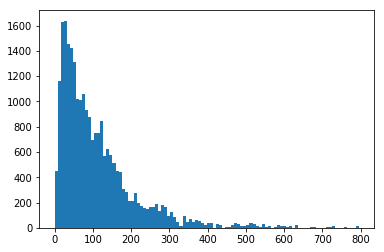

In [6]:
data = pd.read_csv('USvideos.csv', usecols=[4,7,8,9,15]).dropna()

lengths = [len(s.split()) for s in data['description']]

plt.hist(lengths, bins=100)

In [7]:
sum(lengths) / len(lengths)

110.50756926592402

### Scatter Plots

Text(0.5,1,'views vs dislikes')

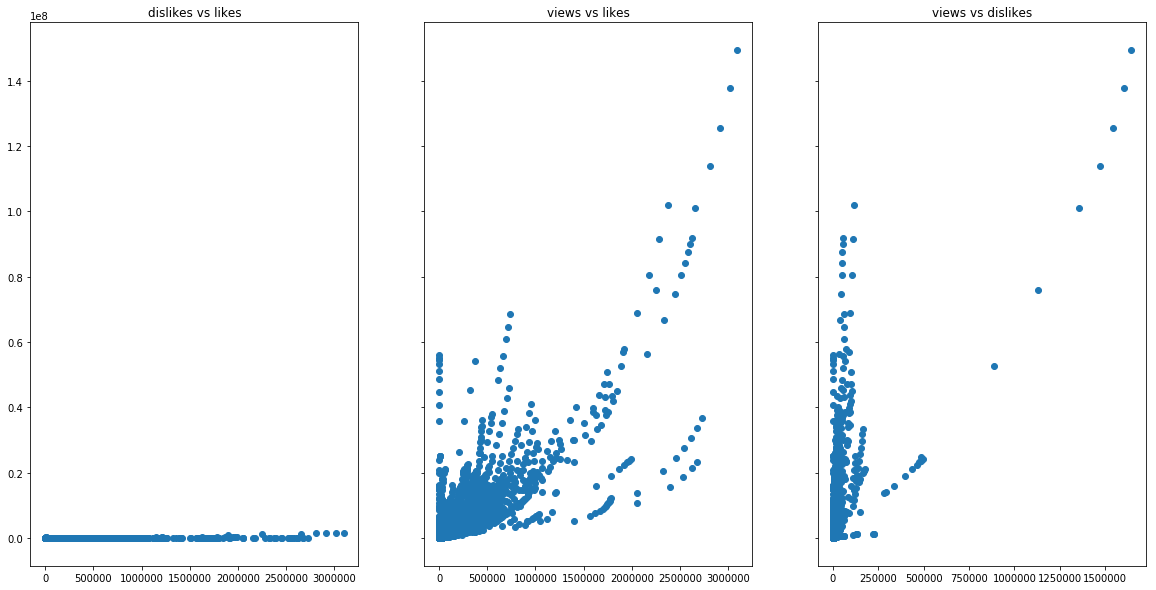

In [8]:
fig, ax = plt.subplots(1,3, figsize=(20,10), sharey=True)
ax[0].scatter(likes, dislikes)
ax[0].set_title('dislikes vs likes')
ax[1].scatter(likes, views)
ax[1].set_title('views vs likes')
ax[2].scatter(dislikes, views)
ax[2].set_title('views vs dislikes')

Text(0.5,1,'views vs dislikes (log)')

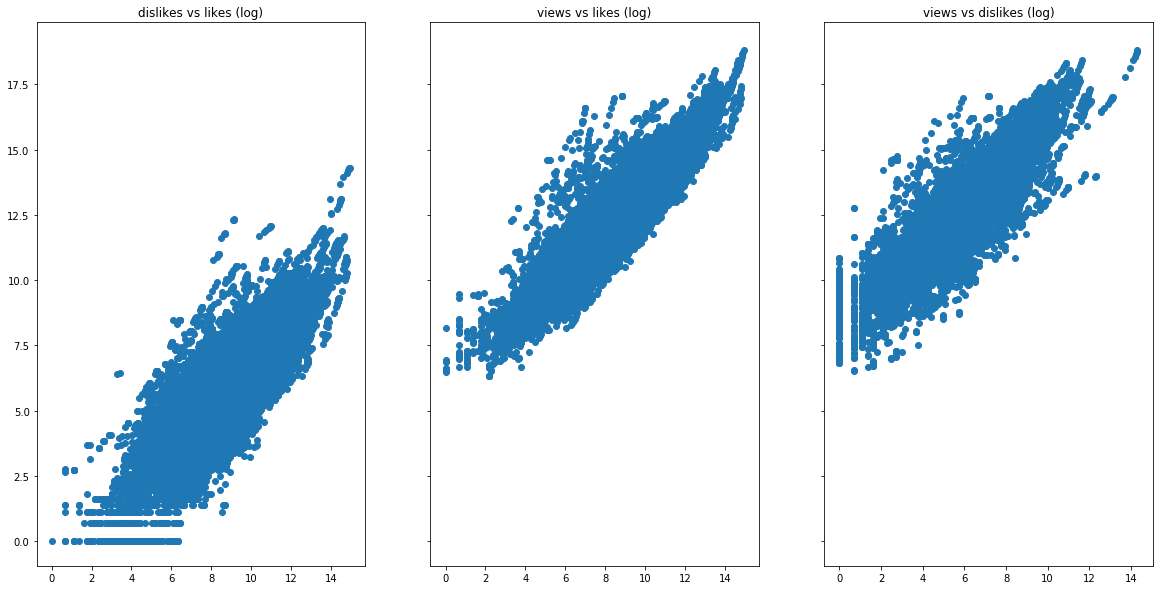

In [9]:
fig, ax = plt.subplots(1,3, figsize=(20,10), sharey=True)
ax[0].scatter(np.log(likes), np.log(dislikes))
ax[0].set_title('dislikes vs likes (log)')
ax[1].scatter(np.log(likes), np.log(views))
ax[1].set_title('views vs likes (log)')
ax[2].scatter(np.log(dislikes), np.log(views))
ax[2].set_title('views vs dislikes (log)')

Text(0.5,1,'likes/dislikes vs views')

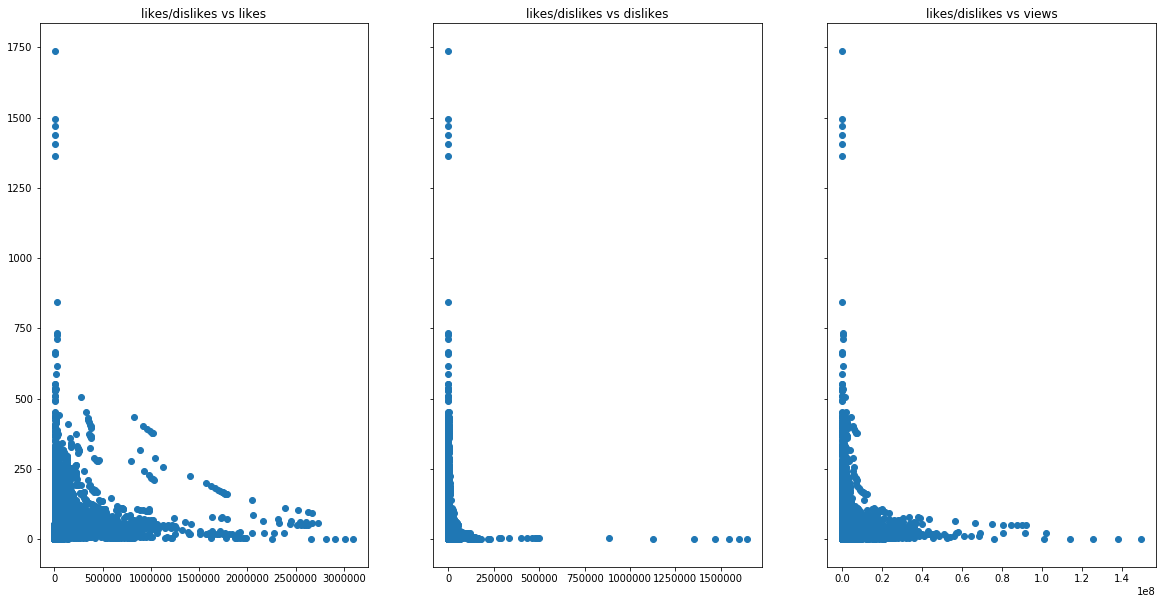

In [10]:
fig, ax = plt.subplots(1,3, figsize=(20,10), sharey=True)
ax[0].scatter(likes, likes/dislikes)
ax[0].set_title('likes/dislikes vs likes')
ax[1].scatter(dislikes, likes/dislikes)
ax[1].set_title('likes/dislikes vs dislikes')
ax[2].scatter(views, likes/dislikes)
ax[2].set_title('likes/dislikes vs views')

### Distribution of likes, dislikes and views

Text(0.5,1,'Views')

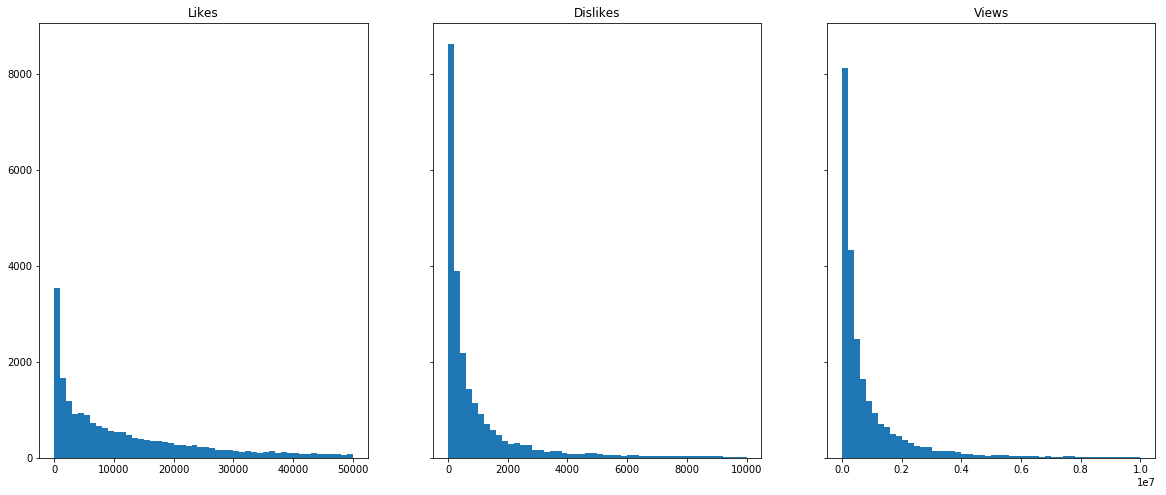

In [11]:
fig, ax = plt.subplots(1,3, sharey =True, figsize=(20,8))
ax[0].hist(likes, bins=50, range=(0,50000))
ax[0].set_title('Likes')
ax[1].hist(dislikes, bins=50, range=(0,10000))
ax[1].set_title('Dislikes')
ax[2].hist(views, bins=50, range=(0,1e7))
ax[2].set_title('Views')

### Distribution of some extracted features

Text(0.5,1,'(likes-dislikes) / views')

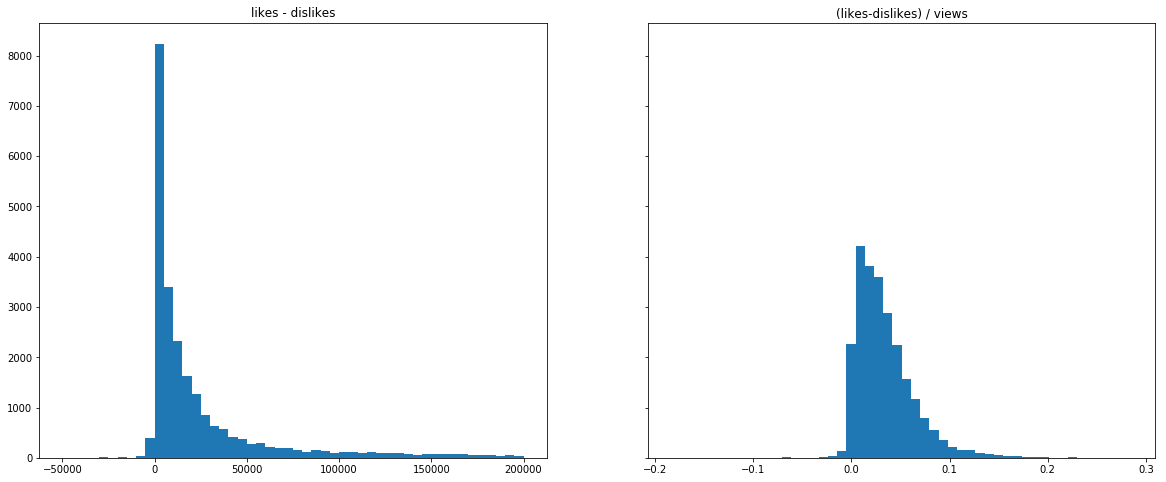

In [12]:
fig, ax = plt.subplots(1,2, sharey =True, figsize=(20,8))
ax[0].hist(likes-dislikes, bins=50, range=(-5e4,2e5))
ax[0].set_title('likes - dislikes')
ax[1].hist((likes-dislikes) / views, bins = 50)
ax[1].set_title('(likes-dislikes) / views')

Text(0.5,1,'likes / views')

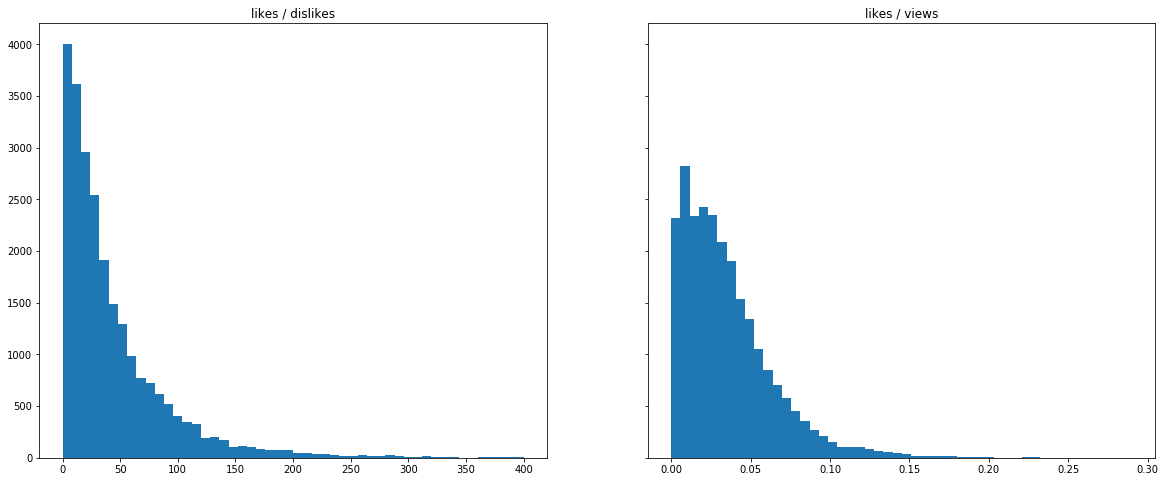

In [13]:
fig, ax = plt.subplots(1,2, sharey =True, figsize=(20,8))
ax[0].hist(likes / dislikes, bins=50, range=(0,400))
ax[0].set_title('likes / dislikes')
ax[1].hist(likes/views, bins=50)
ax[1].set_title('likes / views')

Text(0.5,1,'log((likes+1)/views)')

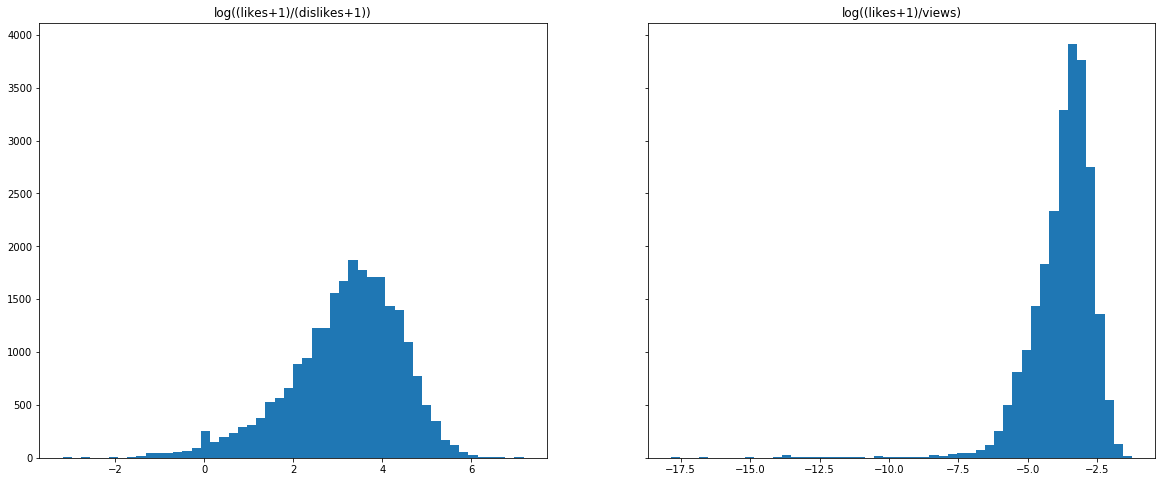

In [14]:
fig, ax = plt.subplots(1,2, sharey =True, figsize=(20,8))
ax[0].hist(np.log((likes+1)/(dislikes+1)), bins=50)
ax[0].set_title('log((likes+1)/(dislikes+1))')
ax[1].hist(np.log((likes+1)/views), bins=50)
ax[1].set_title('log((likes+1)/views)')

## Experiments

### Model 1 : description -> category

I don't think it is very useful

In [19]:
ohe = OneHotEncoder()
y = ohe.fit_transform(category.reshape(-1, 1)).toarray()

X_train, X_test, y_train, y_test = train_test_split(descriptions, y, test_size=0.2)

NUM_CLASSES = y.shape[1]


############# Define the model ################

tf.reset_default_graph()

# define placeholder
labels = tf.placeholder(tf.float32, [BATCH_SIZE, NUM_CLASSES])
input_X = tf.placeholder(tf.int32, [BATCH_SIZE, MAX_SEQ_LENGTH])

# look up word vectors for the ids in each batch of data
data = tf.Variable(tf.zeros([BATCH_SIZE, MAX_SEQ_LENGTH, WORD_DIM]),dtype=tf.float32)
data = tf.nn.embedding_lookup(word_vectors,input_X)
data = tf.cast(data,tf.float32)

# lstm cell
lstmCell = tf.contrib.rnn.BasicLSTMCell(LSTM_UNITS)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
output, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)


weight = tf.Variable(tf.random_uniform([LSTM_UNITS, NUM_CLASSES]))
bias = tf.Variable(tf.constant(0.1, shape=[NUM_CLASSES]))
output = tf.transpose(output, [1, 0, 2])
last = tf.gather(output, int(output.get_shape()[0]) - 1)
y_predicted = (tf.matmul(last, weight) + bias)

correctPred = tf.equal(tf.argmax(y_predicted,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_predicted, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)



############ TRAINING ############

if os.path.isdir("models/model1"):
    ## trained already, then skip the training part
    sess = tf.InteractiveSession()
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('models/model1'))
else:
    sess = tf.InteractiveSession()
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())

    tf.summary.scalar('Loss', loss)
    tf.summary.scalar('Accuracy', accuracy)
    merged = tf.summary.merge_all()
    logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
    writer = tf.summary.FileWriter(logdir, sess.graph)

    for i in range(1, ITERATIONS+1):
        nextBatch, nextBatchLabels = get_batch(X_train, y_train)
        sess.run(optimizer, {input_X: nextBatch, labels: nextBatchLabels})

        #Write summary to Tensorboard
        if (i % 50 == 0):
            summary = sess.run(merged, {input_X: nextBatch, labels: nextBatchLabels})
            writer.add_summary(summary, i)

        #Save the model every 10,000 training iterations
        if i % 10000 == 0:
            save_path = saver.save(sess, "models/model1/pretrained_lstm.ckpt", global_step=i)
            print("saved to %s" % save_path)
    writer.close()


############ TESTING ############    
cost=[]
for i in range(1000):
    nextBatchX, nextBatchLabels = get_batch(X_test, y_test);
    cost.append((sess.run(accuracy, {input_X: nextBatchX, labels: nextBatchLabels})))
    #print("accuracy for batch %d : %d" % (i, cost[i]))
print('Average accuracy = ', sum(cost)/len(cost))


INFO:tensorflow:Restoring parameters from models/model1\pretrained_lstm.ckpt-20000
Average accuracy =  0.97803125


### Model 2 : description -> likes / (dislikes + 1)

In [16]:
y = likes / (dislikes + 1)
X_train, X_test, y_train, y_test = train_test_split(descriptions, y, test_size=0.2)

NUM_CLASSES = 1


############# Define the model ################

tf.reset_default_graph()

# define placeholder
labels = tf.placeholder(tf.float32, [BATCH_SIZE, NUM_CLASSES])
input_X = tf.placeholder(tf.int32, [BATCH_SIZE, MAX_SEQ_LENGTH])

# look up word vectors for the ids in each batch of data
data = tf.Variable(tf.zeros([BATCH_SIZE, MAX_SEQ_LENGTH, WORD_DIM]),dtype=tf.float32)
data = tf.nn.embedding_lookup(word_vectors,input_X)
data = tf.cast(data,tf.float32)

# lstm cell
lstmCell = tf.contrib.rnn.BasicLSTMCell(LSTM_UNITS)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
output, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)


weight = tf.Variable(tf.random_uniform([LSTM_UNITS, NUM_CLASSES]))
bias = tf.Variable(tf.constant(0.1, shape=[NUM_CLASSES]))
output = tf.transpose(output, [1, 0, 2])
last = tf.gather(output, int(output.get_shape()[0]) - 1)
y_predicted = (tf.matmul(last, weight) + bias)


loss = tf.reduce_mean(tf.square(y_predicted-labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)




############ TRAINING ############

if os.path.isdir("models/model2"):
    sess = tf.InteractiveSession()
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('models/model2'))
else:
    sess = tf.InteractiveSession()
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())

    tf.summary.scalar('Loss', loss)
    merged = tf.summary.merge_all()
    logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
    writer = tf.summary.FileWriter(logdir, sess.graph)

    for i in range(1,ITERATIONS+1):
        nextBatch, nextBatchLabels = get_batch(X_train, y_train)
        sess.run(optimizer, {input_X: nextBatch, labels: nextBatchLabels})

        #Write summary to Tensorboard
        if (i % 50 == 0):
            summary = sess.run(merged, {input_X: nextBatch, labels: nextBatchLabels})
            writer.add_summary(summary, i)

        #Save the model every 10,000 training iterations
        if i % 10000 == 0:
            save_path = saver.save(sess, "models/model2/pretrained_lstm.ckpt", global_step=i)
            print("saved to %s" % save_path)
    writer.close()


############ TESTING ############    
cost=[]
for i in range(1000):
    nextBatchX, nextBatchLabels = get_batch(X_test, y_test);
    cost.append((sess.run(loss, {input_X: nextBatchX, labels: nextBatchLabels})))
    #print("Cost for batch %d : %d" % (i, cost[i]))
print('Average cost = ', sum(cost)/len(cost))


INFO:tensorflow:Restoring parameters from models/model2\pretrained_lstm.ckpt-20000
Average cost =  383.923281219


### Model 3 : description -> likes / views

In [17]:
y = likes / views
X_train, X_test, y_train, y_test = train_test_split(descriptions, y, test_size=0.2)

NUM_CLASSES = 1


############# Define the model ################

tf.reset_default_graph()

# define placeholder
labels = tf.placeholder(tf.float32, [BATCH_SIZE, NUM_CLASSES])
input_X = tf.placeholder(tf.int32, [BATCH_SIZE, MAX_SEQ_LENGTH])

# look up word vectors for the ids in each batch of data
data = tf.Variable(tf.zeros([BATCH_SIZE, MAX_SEQ_LENGTH, WORD_DIM]),dtype=tf.float32)
data = tf.nn.embedding_lookup(word_vectors,input_X)
data = tf.cast(data,tf.float32)

# lstm cell
lstmCell = tf.contrib.rnn.BasicLSTMCell(LSTM_UNITS)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
output, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

weight = tf.Variable(tf.random_uniform([LSTM_UNITS, NUM_CLASSES]))
bias = tf.Variable(tf.constant(0.1, shape=[NUM_CLASSES]))
output = tf.transpose(output, [1, 0, 2])
last = tf.gather(output, int(output.get_shape()[0]) - 1)
y_predicted = (tf.matmul(last, weight) + bias)


loss = tf.reduce_mean(tf.square(y_predicted-labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)




############ TRAINING ############

if os.path.isdir("models/model3"):
    sess = tf.InteractiveSession()
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('models/model3'))
else:
    sess = tf.InteractiveSession()
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())

    tf.summary.scalar('Loss', loss)
    merged = tf.summary.merge_all()
    logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
    writer = tf.summary.FileWriter(logdir, sess.graph)

    for i in range(1,ITERATIONS+1):
        nextBatch, nextBatchLabels = get_batch(X_train, y_train)
        sess.run(optimizer, {input_X: nextBatch, labels: nextBatchLabels})

        #Write summary to Tensorboard
        if i % 10000 == 0:
            summary = sess.run(merged, {input_X: nextBatch, labels: nextBatchLabels})
            writer.add_summary(summary, i)

        #Save the model every 10,000 training iterations
        if (i % 10000 == 0 and i != 0):
            save_path = saver.save(sess, "models/model3/pretrained_lstm.ckpt", global_step=i)
            print("saved to %s" % save_path)
    writer.close()


############ TESTING ############    
cost=[]
for i in range(1000):
    nextBatchX, nextBatchLabels = get_batch(X_test, y_test);
    cost.append((sess.run(loss, {input_X: nextBatchX, labels: nextBatchLabels})))
    #print("Cost for batch %d : %d" % (i, cost[i]))
print('Average cost = ', sum(cost)/len(cost))


INFO:tensorflow:Restoring parameters from models/model3\pretrained_lstm.ckpt-20000
Average cost =  0.000189544832108


### Model 4 : descriptions -> log((likes+1) / (dislikes+1))

In [20]:
y = np.log((likes+1) / (dislikes+1))
X_train, X_test, y_train, y_test = train_test_split(descriptions, y, test_size=0.2)

NUM_CLASSES = 1


############# Define the model ################

tf.reset_default_graph()

# define placeholder
labels = tf.placeholder(tf.float32, [BATCH_SIZE, NUM_CLASSES])
input_X = tf.placeholder(tf.int32, [BATCH_SIZE, MAX_SEQ_LENGTH])

# look up word vectors for the ids in each batch of data
data = tf.Variable(tf.zeros([BATCH_SIZE, MAX_SEQ_LENGTH, WORD_DIM]),dtype=tf.float32)
data = tf.nn.embedding_lookup(word_vectors,input_X)
data = tf.cast(data,tf.float32)

# lstm cell
lstmCell = tf.contrib.rnn.BasicLSTMCell(LSTM_UNITS)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
output, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)


weight = tf.Variable(tf.random_uniform([LSTM_UNITS, NUM_CLASSES]))
bias = tf.Variable(tf.constant(0.1, shape=[NUM_CLASSES]))
output = tf.transpose(output, [1, 0, 2])
last = tf.gather(output, int(output.get_shape()[0]) - 1)
y_predicted = (tf.matmul(last, weight) + bias)


loss = tf.reduce_mean(tf.square(y_predicted-labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)



############ TRAINING ############

if os.path.isdir("models/model4"):
    sess = tf.InteractiveSession()
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('models/model4'))
else:
    sess = tf.InteractiveSession()
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())

    tf.summary.scalar('Loss', loss)
    merged = tf.summary.merge_all()
    logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
    writer = tf.summary.FileWriter(logdir, sess.graph)

    for i in range(1,ITERATIONS+1):
        nextBatch, nextBatchLabels = get_batch(X_train, y_train)
        sess.run(optimizer, {input_X: nextBatch, labels: nextBatchLabels})

        #Write summary to Tensorboard
        if (i % 50 == 0):
            summary = sess.run(merged, {input_X: nextBatch, labels: nextBatchLabels})
            writer.add_summary(summary, i)

        #Save the model every 10,000 training iterations
        if i % 10000 == 0:
            save_path = saver.save(sess, "models/model4/pretrained_lstm.ckpt", global_step=i)
            print("saved to %s" % save_path)
    writer.close()


############ TESTING ############    
cost=[]
for i in range(1000):
    nextBatchX, nextBatchLabels = get_batch(X_test, y_test);
    cost.append((sess.run(loss, {input_X: nextBatchX, labels: nextBatchLabels})))
    #print("Cost for batch %d : %d" % (i, cost[i]))
print('Average cost = ', sum(cost)/len(cost))


INFO:tensorflow:Restoring parameters from models/model4\pretrained_lstm.ckpt-20000
Average cost =  0.117641990528


### Model 5 : descriptions ->  log((likes+1) / views)

In [18]:
y = np.log((likes+1) / views)
X_train, X_test, y_train, y_test = train_test_split(descriptions, y, test_size=0.2)

NUM_CLASSES = 1


############# Define the model ################

tf.reset_default_graph()

# define placeholder
labels = tf.placeholder(tf.float32, [BATCH_SIZE, NUM_CLASSES])
input_X = tf.placeholder(tf.int32, [BATCH_SIZE, MAX_SEQ_LENGTH])

# look up word vectors for the ids in each batch of data
data = tf.Variable(tf.zeros([BATCH_SIZE, MAX_SEQ_LENGTH, WORD_DIM]),dtype=tf.float32)
data = tf.nn.embedding_lookup(word_vectors,input_X)
data = tf.cast(data,tf.float32)

# lstm cell
lstmCell = tf.contrib.rnn.BasicLSTMCell(LSTM_UNITS)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
output, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)


weight = tf.Variable(tf.random_uniform([LSTM_UNITS, NUM_CLASSES]))
bias = tf.Variable(tf.constant(0.1, shape=[NUM_CLASSES]))
output = tf.transpose(output, [1, 0, 2])
last = tf.gather(output, int(output.get_shape()[0]) - 1)
y_predicted = (tf.matmul(last, weight) + bias)


loss = tf.reduce_mean(tf.square(y_predicted-labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)



############ TRAINING ############

if os.path.isdir("models/model5"):
    sess = tf.InteractiveSession()
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('models/model5'))
else:
    sess = tf.InteractiveSession()
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())

    tf.summary.scalar('Loss', loss)
    merged = tf.summary.merge_all()
    logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
    writer = tf.summary.FileWriter(logdir, sess.graph)

    for i in range(1,ITERATIONS+1):
        nextBatch, nextBatchLabels = get_batch(X_train, y_train)
        sess.run(optimizer, {input_X: nextBatch, labels: nextBatchLabels})

        #Write summary to Tensorboard
        if (i % 50 == 0):
            summary = sess.run(merged, {input_X: nextBatch, labels: nextBatchLabels})
            writer.add_summary(summary, i)

        #Save the model every 10,000 training iterations
        if i % 10000 == 0:
            save_path = saver.save(sess, "models/model5/pretrained_lstm.ckpt", global_step=i)
            print("saved to %s" % save_path)
    writer.close()


############ TESTING ############    
cost=[]
for i in range(1000):
    nextBatchX, nextBatchLabels = get_batch(X_test, y_test);
    cost.append((sess.run(loss, {input_X: nextBatchX, labels: nextBatchLabels})))
    #print("Cost for batch %d : %d" % (i, cost[i]))
print('Average cost = ', sum(cost)/len(cost))


INFO:tensorflow:Restoring parameters from models/model5\pretrained_lstm.ckpt-20000
Average cost =  0.151906682469


### Model 6 : descriptions -> (likes - dislikes) / views

In [ ]:
y = (likes - dislikes) / views
X_train, X_test, y_train, y_test = train_test_split(descriptions, y, test_size=0.2)

NUM_CLASSES = 1


############# Define the model ################

tf.reset_default_graph()

# define placeholder
labels = tf.placeholder(tf.float32, [BATCH_SIZE, NUM_CLASSES])
input_X = tf.placeholder(tf.int32, [BATCH_SIZE, MAX_SEQ_LENGTH])

# look up word vectors for the ids in each batch of data
data = tf.Variable(tf.zeros([BATCH_SIZE, MAX_SEQ_LENGTH, WORD_DIM]),dtype=tf.float32)
data = tf.nn.embedding_lookup(word_vectors,input_X)
data = tf.cast(data,tf.float32)

# lstm cell
lstmCell = tf.contrib.rnn.BasicLSTMCell(LSTM_UNITS)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
output, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)


weight = tf.Variable(tf.random_uniform([LSTM_UNITS, NUM_CLASSES]))
bias = tf.Variable(tf.constant(0.1, shape=[NUM_CLASSES]))
output = tf.transpose(output, [1, 0, 2])
last = tf.gather(output, int(output.get_shape()[0]) - 1)
y_predicted = (tf.matmul(last, weight) + bias)


loss = tf.reduce_mean(tf.square(y_predicted-labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)



############ TRAINING ############

if os.path.isdir("models/model6"):
    sess = tf.InteractiveSession()
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('models/model6'))
else:
    sess = tf.InteractiveSession()
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())

    tf.summary.scalar('Loss', loss)
    merged = tf.summary.merge_all()
    logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
    writer = tf.summary.FileWriter(logdir, sess.graph)

    for i in range(1, ITERATIONS+1):
        nextBatch, nextBatchLabels = get_batch(X_train, y_train)
        sess.run(optimizer, {input_X: nextBatch, labels: nextBatchLabels})

        #Write summary to Tensorboard
        if (i % 50 == 0):
            summary = sess.run(merged, {input_X: nextBatch, labels: nextBatchLabels})
            writer.add_summary(summary, i)

        #Save the model every 10,000 training iterations
        if i % 10000 == 0:
            save_path = saver.save(sess, "models/model6/pretrained_lstm.ckpt", global_step=i)
            print("saved to %s" % save_path)
    writer.close()


############ TESTING ############    
cost=[]
for i in range(1000):
    nextBatchX, nextBatchLabels = get_batch(X_test, y_test);
    cost.append((sess.run(loss, {input_X: nextBatchX, labels: nextBatchLabels})))
    #print("Cost for batch %d : %d" % (i, cost[i]))
print('Average cost = ', sum(cost)/len(cost))


INFO:tensorflow:Restoring parameters from models/model6\pretrained_lstm.ckpt-20000


## Something we need to consider and discuss

### Cleaning the description
- special attention to the punctuations and the contractions ('s, 're, 've, ...)
- handling links in the descriptions?

### Handling words that do not appear in the pretrained word2vec model
- assign to a random word for this unseen word, which may mess up the meaning
- ignore them
- create a new vector for these words, but this may mess up distance between words, and thus the meaning
- use a discounted sum of the word vectors in the same description
- other ways?

### Ways of quantifying the popularity
- why log?
- how to determine the number that prevents division by zero or log 0
- which one is better?
